This is the modified official example of DCGAN on the keras official documentation. [Link](https://keras.io/examples/generative/conditional_gan/)

Modifications include adding and removing some comments. Some of the comments were generated with Copilot.

In [1]:
import os

import keras

from keras import layers, ops, utils
import numpy as np

2025-01-27 08:46:37.063022: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-27 08:46:37.072398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737938797.084598   30989 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737938797.087976   30989 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 08:46:37.099327: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 32
latent_dim = 128

In [3]:
from dataset.loader import SPOTS10
X_train, y_train, X_test, y_test = SPOTS10()

# Add a color channel (size 1) to the images
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

all_digits = np.concatenate([X_train, X_test])
all_labels = np.concatenate([y_train, y_test])

print(f"Shape of raw training images: {all_digits.shape}")
print(f"Shape of raw training labels: {all_labels.shape}")

all_digits = all_digits.astype('float32') / 255.0
all_digits = np.reshape(all_digits, (-1, image_size, image_size, num_channels))
all_labels = keras.utils.to_categorical(all_labels, num_classes)

File dataset/test-images-idx3-ubyte.gz already exists, skipping download
File dataset/test-labels-idx1-ubyte.gz already exists, skipping download
File dataset/train-images-idx3-ubyte.gz already exists, skipping download
File dataset/train-labels-idx1-ubyte.gz already exists, skipping download
File utilities/spots_10_loader.py already exists, skipping download
All files downloaded successfully
Shape of raw training images: (50000, 1, 32, 32)
Shape of raw training labels: (50000,)


`keras.utils` offers some Python & NumPy utilities, a dedicated list of them are given [there](https://keras.io/api/utils/python_utils/).

For example:

- `split_dataset`: Splits a dataset into a left half and a right half;
- `pack_x_y_sample_weight`: Pack user-provided data into a tuple;
- `get_file`: Download a file from the url if not already in cache;
- `to_categorical`: Convert a class vector (integers) to binary class matrix;

In [4]:
# Create torch dataloader
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (50000, 32, 32, 1)
Shape of training labels: (50000, 10)


I0000 00:00:1737938799.361552   30989 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6156 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6


In [5]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


In [6]:
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((image_size, image_size, discriminator_in_channels)), # 32x32x11
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding="valid"), # 14x14x64
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"), # 7x7x128
        layers.LeakyReLU(negative_slope=0.2),
        layers.GlobalMaxPooling2D(), # 128
        layers.Dense(1), # 1
    ],
    name="discriminator",
)

generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        layers.Dense(7 * 7 * generator_in_channels), # 6762
        layers.LeakyReLU(negative_slope=0.2),
        layers.Reshape((7, 7, generator_in_channels)), # 7x7x138
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"), # 14x14x128
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, (6, 6), strides=(2, 2), padding="valid"), # 28x28x128
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(num_channels, (7, 7), activation="sigmoid", padding="same"), # 32x32x1
    ],
    name="generator",
)

discriminator.summary(), generator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,649 (358.00 KB)

 Trainable params: 91,649 (358.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 6762)           │       939,918 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 6762)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 138)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       282,752 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       589,952 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 1)      │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,818,895 (6.94 MB)

 Trainable params: 1,818,895 (6.94 MB)

 Non-trainable params: 0 (0.00 B)

(None, None)

In [7]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data
        real_images, one_hot_labels = data
        # real_images.shape = (batch_size, 28, 28, 1)
        # one_hot_labels.shape = (batch_size, 10)

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None] # Now the shape is (batch_size, 10, 1, 1)
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        ) # Now the shape is (batch_size, 10, 28, 28)
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        ) # Now the shape is (batch_size, 28, 28, 10)
        # That is, every pixel in the image has the one-hot label of the image.

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        ) # (batch_size, 128)
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        ) # (batch_size, 138)

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels) # (batch_size, 28, 28, 1)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        ) # (batch_size, 28, 28, 11)
        real_image_and_labels = ops.concatenate(
            [real_images, image_one_hot_labels], -1
        ) # (batch_size, 28, 28, 11)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        ) # (2 * batch_size, 28, 28, 11)

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        ) # (2 * batch_size, 1)

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


In [8]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=20)

Epoch 1/20


I0000 00:00:1737938802.912022   31055 service.cc:148] XLA service 0x73bfcc002160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737938802.912038   31055 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-01-27 08:46:42.948210: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737938803.146040   31055 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-27 08:46:43.801656: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 8 bytes spill stores, 8 bytes spill loads

2025-01-27 08:46:43.846589: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 112 bytes spill 

 13/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - d_loss: 0.6706 - g_loss: 0.7293

I0000 00:00:1737938806.965045   31055 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - d_loss: 0.6294 - g_loss: 1.0473
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - d_loss: 0.6087 - g_loss: 1.1528
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - d_loss: 0.7086 - g_loss: 0.7557
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - d_loss: 0.7005 - g_loss: 0.7437
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - d_loss: 0.7176 - g_loss: 0.7215
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - d_loss: 0.7134 - g_loss: 0.7610
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - d_loss: 0.7101 - g_loss: 0.7258
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - d_loss: 0.7123 - g_loss: 0.7698
Epoch 9/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - d_loss: 0.7111 - g_loss: 0.7124
Epoch 10/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - d_loss: 0.6992 - g_loss: 0.7367
Epoch 11/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - d_loss: 0.7115 - g_loss: 0.7078
Epoch 12/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 

In [9]:
# We first extract the trained generator from our Conditional GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = keras.random.normal(shape=(1, latent_dim), seed=1337)
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    # Calculate the interpolation vector between the two labels.
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = ops.concatenate([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 2  # @param {type:"slider", min:0, max:9, step:1}
end_class = 6  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step



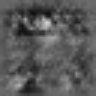

In [10]:
import imageio
from tensorflow_docs.vis import embed

fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images[:, :, :, 0], fps=1)
embed.embed_file("animation.gif")